# Cosinor Regression Model
A cosinor regression model fits a cosine curve to periodic biological or cyclical data (like circadian rhythms) to quantify its rhythm, estimating key parameters: the MESOR (midline), Amplitude (strength of rhythm), and Acrophase (timing of peak activity). It uses linear regression with sine and cosine terms to linearize the model, making it suitable for General Linear Models (GLM) or Generalized Linear Models (GZLM), handling non-negative data and unevenly spaced data well, and is widely used in health research to detect and characterize rhythms. 

In [58]:
# import libraries
import pandas as pd

import sys
sys.path.append('../0_DataPreparation')
from utils import plot_missing_heatmap

# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error


In [59]:
# read train and validation data frame from ../data/processed

df_train_clean = pd.read_csv("../data/processed/df_train_data_cleaned.csv")
df_validation_clean = pd.read_csv("../data/processed/df_validation_data_cleaned.csv")
df_test_clean = pd.read_csv("../data/processed/df_test_data_cleaned.csv")

# convert Datum column to datetime
df_train_clean['Datum'] = pd.to_datetime(df_train_clean['Datum'])
df_validation_clean['Datum'] = pd.to_datetime(df_validation_clean['Datum'])
df_test_clean['Datum'] = pd.to_datetime(df_test_clean['Datum'])


# add month to train
df_train_clean['month'] = df_train_clean['Datum'].dt.month
# add month to validation
df_validation_clean['month'] = df_validation_clean['Datum'].dt.month
# add month to test
df_test_clean['month']= df_test_clean['Datum'].dt.month

# print shape of the datasets
print(f"Train data shape: {df_train_clean.shape}")
print(f"Validation data shape: {df_validation_clean.shape}")
print(f"Test data shape: {df_test_clean.shape}")
df_train_clean.head()

Train data shape: (7487, 18)
Validation data shape: (1841, 18)
Test data shape: (1830, 17)


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,day_of_week,is_saturday,is_sunday,sunshine_duration,temperature_2m_mean,sunshine_hours,public_holiday,school_holiday,next_day_holiday,month
0,2013-07-01,0.0,6.0,17.8375,15.0,1.0,148.828353,148.828353,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
1,2013-07-01,0.0,6.0,17.8375,15.0,2.0,535.856285,221.786925,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
2,2013-07-01,0.0,6.0,17.8375,15.0,3.0,201.198426,592.534505,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
3,2013-07-01,0.0,6.0,17.8375,15.0,4.0,65.890169,311.369828,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
4,2013-07-01,0.0,6.0,17.8375,15.0,5.0,317.475875,109.314600,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7


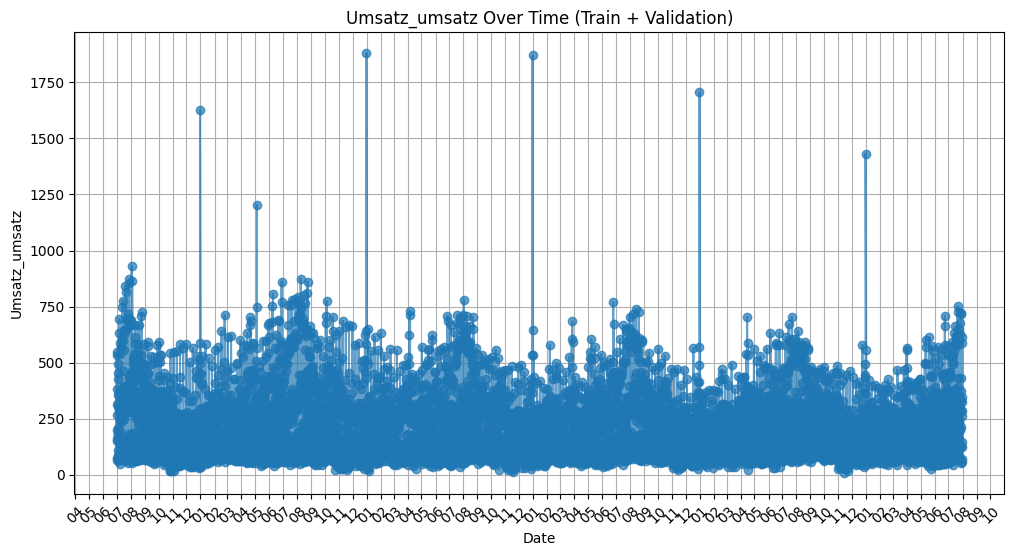

In [60]:
# first visualize all Umzatz_umsatz over timeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# combine train and validation for full timeline visualization (exclude test as per earlier instructions)
df_combined = pd.concat([df_train_clean[['Datum', 'Umsatz_umsatz']], df_validation_clean[['Datum', 'Umsatz_umsatz']]], ignore_index=True)
df_combined = df_combined.sort_values('Datum')

# plot line graph of Umsatz_umsatz over time
plt.figure(figsize=(12, 6))
plt.plot(df_combined['Datum'], df_combined['Umsatz_umsatz'], marker='o', linestyle='-', alpha=0.7)
plt.title('Umsatz_umsatz Over Time (Train + Validation)')
plt.xlabel('Date')
plt.ylabel('Umsatz_umsatz')

# format x-axis to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Cosinor

In [61]:
import numpy as np

# define period (e.g., 365 for yearly cycle; adjust as needed, e.g., 7 for weekly)
period = 30  # days

# add time variable (days since start)
df_train_clean['t'] = (df_train_clean['Datum'] - df_train_clean['Datum'].min()).dt.days
df_validation_clean['t'] = (df_validation_clean['Datum'] - df_validation_clean['Datum'].min()).dt.days

# compute cosinor terms
omega = 2 * np.pi / period
df_train_clean['cos_term'] = np.cos(omega * df_train_clean['t'])
df_train_clean['sin_term'] = np.sin(omega * df_train_clean['t'])
df_validation_clean['cos_term'] = np.cos(omega * df_validation_clean['t'])
df_validation_clean['sin_term'] = np.sin(omega * df_validation_clean['t'])


In [62]:
# ignore some columns
drop_columns = ['Datum', 'umsatz_rolling7','temperature_2m_mean','sunshine_duration','is_saturday','is_sunday']

# drop columns if present
drop_columns = [col for col in drop_columns if col in df_train_clean.columns]

# drop columns from train and validation datasets
df_train_clean = df_train_clean.drop(columns=drop_columns)
df_validation_clean = df_validation_clean.drop(columns=drop_columns)


In [63]:
categorical_cols = ['Warengruppe_umsatz', 'day_of_week','public_holiday','next_day_holiday','month','school_holiday']  # example; replace with actual categoricals
# filter to only those present in the data
categorical_cols = [col for col in categorical_cols if col in df_train_clean.columns]

df_train_clean = pd.get_dummies(df_train_clean, columns=categorical_cols, drop_first=False)  # drop_first=True to avoid multicollinearity if needed
df_validation_clean = pd.get_dummies(df_validation_clean, columns=categorical_cols, drop_first=False)

# ensure train and validation have the same columns (in case of missing categories in validation)
df_validation_clean = df_validation_clean.reindex(columns=df_train_clean.columns, fill_value=0)

In [64]:

# prepare features and target for cosinor model (using only cos and sin terms)
target = 'Umsatz_umsatz'
X_train_cosinor = df_train_clean[['cos_term', 'sin_term']]
y_train = df_train_clean[target]
X_validation_cosinor = df_validation_clean[['cos_term', 'sin_term']]
y_validation = df_validation_clean[target]

# fit the cosinor model
cosinor_model = LinearRegression()
cosinor_model.fit(X_train_cosinor, y_train)

# extract cosinor parameters
intercept = cosinor_model.intercept_
coef_cos = cosinor_model.coef_[0]
coef_sin = cosinor_model.coef_[1]
mesor = intercept
amplitude = np.sqrt(coef_cos**2 + coef_sin**2)
acrophase = np.arctan2(coef_sin, coef_cos)

print(f"MESOR (midline): {mesor:.4f}")
print(f"Amplitude: {amplitude:.4f}")
print(f"Acrophase (radians): {acrophase:.4f}")

# predict and evaluate
y_train_pred = cosinor_model.predict(X_train_cosinor)
y_validation_pred = cosinor_model.predict(X_validation_cosinor)

r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train:.4f}")
print(f"R2 on validation: {r2_validation:.4f}")
print(f"MAPE on validation: {mape_validation:.4f}")

MESOR (midline): 209.3535
Amplitude: 4.1589
Acrophase (radians): 1.5543
R2 on train: 0.0004
R2 on validation: -0.0110
MAPE on validation: 0.8336
